In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] ='nearest'
plt.rcParams['font.size'] = 14
import matplotlib.patches as patches
import math
import time
import scipy.special as special
import pyroomacoustics as pra

import sys
import os
sys.path.append(os.pardir)
from wave_func import *
from sf_util import *

In [23]:
# Config
c = 340.29  # sound speed
freq = 1000  # frequency for narrowband
f_target = np.arange(100,1501,100)  # target frequency for broadband
fbin = np.arange(100,2001,100)  # frequency bin for broadband
L = 20  # number of selection

# Simulation field
x_lim = [-1.5,2.5]
y_lim = [-2,2]
dx = 0.01
dy = 0.01
xticks = np.arange(x_lim[0], x_lim[1]+1e-4, dx)
yticks = np.arange(y_lim[0], y_lim[1]+1e-4, dy)
X, Y = np.meshgrid(xticks, yticks)

roomX = [-2.5,2.5]
roomY = [-2,2]

In [24]:
# Candidate position
posSrc = np.load("posCandidate.npy")
posSrc[:,0] += 0.5

# Reproduction area
radi = 0.5  # radi
cent = [0.5,0.3,0]  # center

# Evaluation point
posEval = []
for i, x in enumerate(xticks):
    for j, y in enumerate(yticks):
        if (x-cent[0])**2 + (y-cent[1])**2 <= radi**2:
            posEval.append([x,y,0])
posEval = np.array(posEval)

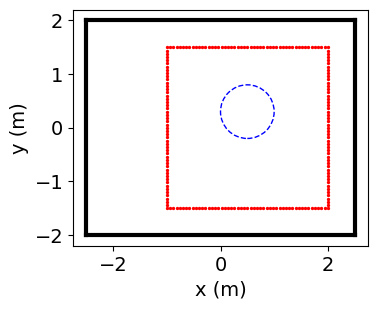

In [25]:
# Plot field
# 2D
fig, ax = plt.subplots(figsize=(4,4))
ax.grid(False)
ax.scatter(posSrc[:,0],posSrc[:,1], s=10, linewidth=0.8, marker='.', c="r", label="src")
ax.set_aspect('equal')
obj_zone = patches.Circle(xy=cent, radius=radi, ec="b", fill=False, ls='dashed')
ax.add_patch(obj_zone)

# walls
plt.plot(roomX,[roomY[0],roomY[0]],linewidth=3,c="black")
plt.plot(roomX,[roomY[1],roomY[1]],linewidth=3,c="black")
plt.plot([roomX[0],roomX[0]],roomY,linewidth=3,c="black")
plt.plot([roomX[1],roomX[1]],roomY,linewidth=3,c="black")

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

plt.tight_layout()

# plt.savefig("figs/field2D.png")
plt.show()

## Narrowband

Truncation order :  19


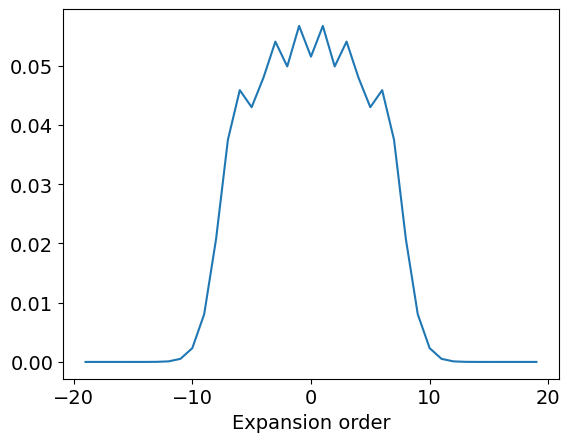

In [26]:
# Wave number
k = 2*np.pi*freq/c

# Weight matrix
N = math.ceil(2*k*radi)  # >> k*radi
print("Truncation order : ", N)

W = np.zeros((2*N+1,2*N+1), dtype=complex)
for n in range(-N, N+1):
    idx = n+N
    W[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    

plt.plot(range(-N, N+1), np.diag(W.real))
plt.xlabel("Expansion order")
plt.show()

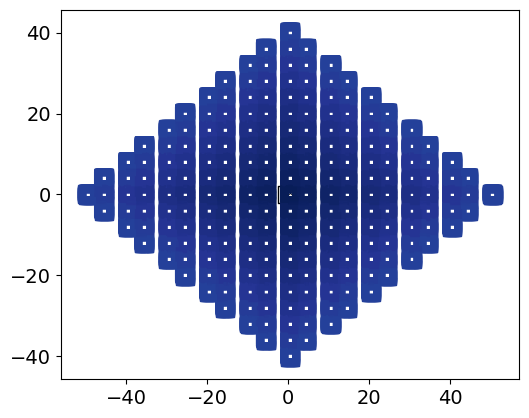

In [27]:
# Room settings

# Config
# rt60 = 0.2  # seconds
# room_dim = [5, 4]  # meters
# e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)
# print("e_absorption : ",e_absorption, "\nmax_order : ", max_order)

e_absorption = 0.2
reflect = np.sqrt(1-e_absorption)
max_order = 10

corners = np.array([[roomX[0],roomY[0]], [roomX[1],roomY[0]], [roomX[1],roomY[1]], [roomX[0],roomY[1]]]).T  # [x,y]

def MirrImgSrcModel(corners, e_absorption, max_order, posSrc):
    # room
    room = pra.Room.from_corners(corners, materials=pra.Material(e_absorption), fs=16000, t0=0.0, max_order=max_order)

    for src in posSrc:
        room.add_source(src[:2])

    # microphone (dummy)
    room.add_microphone(cent[:2])

    # calculate images
    room.image_source_model()

    # all poisitions of sources and images, orders, index of original source
    srcInfo = np.zeros((1,4))
    for i, src in enumerate(room.sources):
        src_and_imgs = src.get_images().T
        order = src.orders.reshape(-1,1)
        srcInfo = np.vstack((srcInfo, np.block([src_and_imgs, order, np.tile([i], reps=(len(order),1))])))
    srcInfo = srcInfo[1:]
    
    return srcInfo, room

_, room_all = MirrImgSrcModel(corners, e_absorption, max_order, posSrc)

# Plot
fig, ax = room_all.plot(img_order=max_order)

In [28]:
# Transfer function matrix
G_mm = np.zeros((2*N+1,len(posSrc)), dtype=complex)
for i, src in enumerate(room_all.sources):
    src_and_imgs = src.get_images().T
    order = src.orders
    for j, pos in enumerate(src_and_imgs):
        decay = reflect**order[j]
        G_mm[:, i] += cylindricalwave_coef(cent[:2], pos, k, N) * decay

1 selected： 112
2 selected： 189
3 selected： 195
4 selected： 161
5 selected： 155
6 selected： 186
7 selected： 65
8 selected： 175
9 selected： 178
10 selected： 158
11 selected： 50
12 selected： 83
13 selected： 68
14 selected： 111
15 selected： 182
16 selected： 169
17 selected： 70
18 selected： 149
19 selected： 5
20 selected： 172


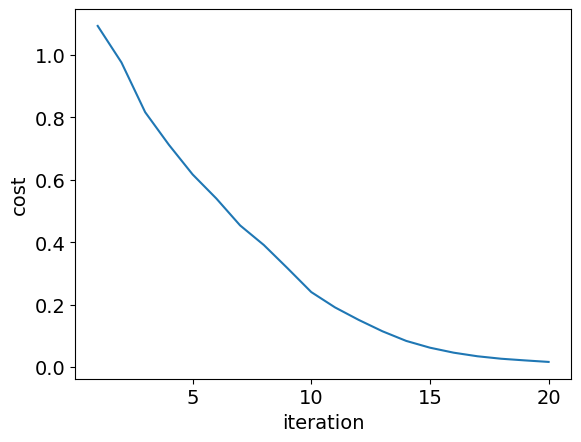

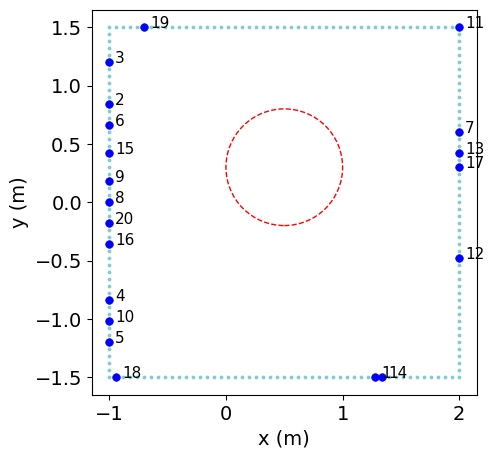

In [29]:
# Source optimization

G = G_mm

# Prior information
Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
mu = np.zeros(2*N+1, dtype=complex)
for i in range(-N,N+1):
    for j in range(-N,N+1):
        if i != j:
            Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4))
        else:
            Sig[j+N,i+N] = np.pi/2

# Cost function
def cost_func(srcIdx, G, Sig, mu, lmd=1e-3, W=None):
    if W is None:
        W = np.diag(np.ones(len(G)))
    Phi = np.zeros((len(G[0]),len(srcIdx)))
    for s,idx in enumerate(srcIdx):
        Phi[idx,s] = 1
    A = np.linalg.inv(Phi.T @ G.conj().T @ W @ G @ Phi + lmd * np.eye(len(srcIdx)))
    D = W - W@G@Phi@A@Phi.T@G.conj().T@W.T
    cost = np.trace(D@Sig)+mu.conj().T@D@mu
    return cost.real
    
# Greedy algorithm

select = []
unselect = list(range(len(posSrc)))
costs = []

while len(select) < L:
    minval = 1e6
    for i in unselect:
        J = cost_func(select+[i], G, Sig, mu, lmd=1e-5, W=W)
        if J < minval:
            minval = J
            i_src = i

    select.append(i_src)
    unselect.remove(i_src)

    print(len(select),"selected：", i_src)
    costs.append(minval)


# Cost
plt.plot(np.arange(len(costs))+1,costs)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.show()

# Selected position
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
ax.scatter(posSrc[select][:,0],posSrc[select][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[select]):
    pos = [s[0]+0.05,s[1]]
    plt.annotate(i+1,pos,fontsize=11)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.add_patch(obj_zone)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid(False)
ax.set_aspect('equal')
plt.show()

In [30]:
# Regular position
# Regular A
regAIdx = np.linspace(126, 200, L, dtype=int)+17
regAIdx[regAIdx>=200] -= 200

# Regular B
regBIdx = np.linspace(0, 200, L, dtype=int)+np.ceil(100/len(select)).astype(int)
regBIdx[regBIdx>=200] -= 200

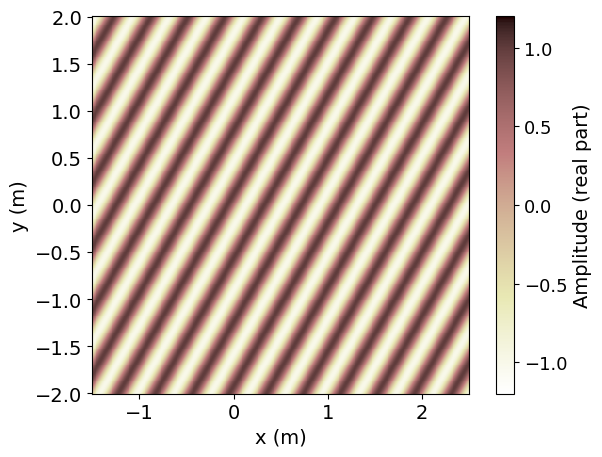

In [31]:
# Desired sound field ( and coefficents ) example

# Planewave
phi = -np.pi/6
theta = np.pi/2
des_coefs = planewave_coef(cent, phi, theta, k, N, amp=1, cylind=True)

# Cyrindrical wave
# spos = np.array([1.0, 0.3])
# des_coefs = cylindricalwave_coef(cent[:2], spos, k, N, amp=10)

# Plot
sf_des = np.zeros((len(xticks),len(yticks)), dtype=complex)
for i, x in enumerate(xticks):
    for j, y in enumerate(yticks):
        # plane wave
        kvec = [k*np.cos(phi), k*np.sin(phi)]
        sf_des[j,i] = planewave([x-cent[0],y-cent[1],0], phi, theta, k)

        # cylindrical wave
        # sf_des[j,i] = cylindricalwave([x,y], [spos[0],spos[1]], k, amp=10)

fig, ax = plot_amp(xticks, yticks, sf_des)
plt.show()

In [32]:
# Calculate example distribution ( takes about 15 minuites ... )
G_opt = G[:, select]
G_regA = G[:, regAIdx]
G_regB = G[:, regBIdx]

lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )

lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )

lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

optSrc, _ = MirrImgSrcModel(corners, e_absorption, max_order, posSrc[select,:2])
regASrc, _ = MirrImgSrcModel(corners, e_absorption, max_order, posSrc[regAIdx,:2])
regBSrc, _ = MirrImgSrcModel(corners, e_absorption, max_order, posSrc[regBIdx,:2])

rvec = np.array([xticks.tolist()*len(yticks), np.repeat(yticks, len(xticks))]).T
sf_opt = np.zeros(X.shape, dtype=complex)
sf_regA = np.zeros(X.shape, dtype=complex)
sf_regB = np.zeros(X.shape, dtype=complex)

t1 = time.time()
for s in optSrc:
    decay = reflect**s[2]
    amp = drvOpt[s[3].astype(int)]*decay
    amp = np.tile(amp, reps=len(rvec))
    svec = np.repeat([s[:2]],len(rvec),axis=0)
    sf_opt += cylindricalwave(rvec, svec, k, amp=amp).reshape(X.shape)

for s in regASrc:
    decay = reflect**s[2]
    amp = drvRegA[s[3].astype(int)]*decay
    amp = np.tile(amp, reps=len(rvec))
    svec = np.repeat([s[:2]],len(rvec),axis=0)
    sf_regA += cylindricalwave(rvec, svec, k, amp=amp).reshape(X.shape)

for s in regBSrc:
    decay = reflect**s[2]
    amp = drvRegB[s[3].astype(int)]*decay
    amp = np.tile(amp, reps=len(rvec))
    svec = np.repeat([s[:2]],len(rvec),axis=0)
    sf_regB += cylindricalwave(rvec, svec, k, amp=amp).reshape(X.shape)
t2 = time.time()
t2-t1

1413.1794860363007

In [33]:
# Transfer function for evaluation points
t1 = time.time()

# cent, radii, posEval, freqなどを変更した場合，再計算が必要
G_eval = np.zeros((len(posEval),len(posSrc)), dtype=complex)
for i, src in enumerate(room_all.sources):
    src_and_imgs = src.get_images().T
    order = src.orders
    print(i)
    for j, pos in enumerate(src_and_imgs):
        decay = reflect**order[j]
        svec = np.repeat([pos],len(posEval),axis=0)
        G_eval[:, i] += cylindricalwave(posEval[:,:2], svec, k, amp=decay)
np.save("G_eval_nb.npy", G_eval)

# 計算済みの場合
# G_eval = np.load("G_eval_nb.npy")

t2 = time.time()
t2-t1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


97.61488103866577

Average SDR
　Optimized:  21.59  (dB)
　Regular A:  15.98  (dB)
　Regular B:  14.34  (dB)


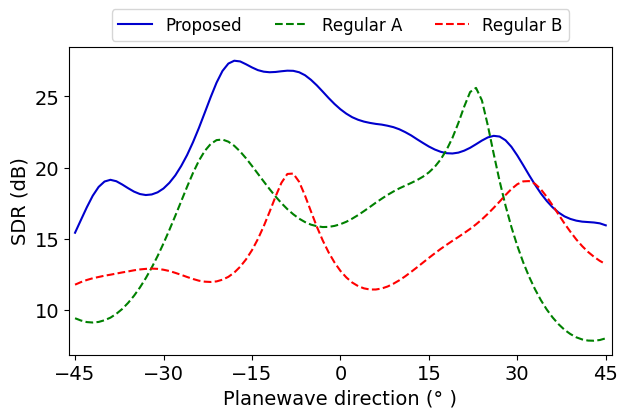

In [34]:
# Comparison
angles = np.arange(-45,46)*np.pi/180
sdrs = []

cnt = 0
theta = np.pi/2
for phi in angles:
    des = []
    for pos in posEval:
        des.append(planewave([pos[0]-cent[0], pos[1]-cent[1], 0], phi, theta, k))
    des = np.array(des)
    
    des_coefs = planewave_coef(rvec, phi, theta, k, N, amp=1, cylind=True)
    
    # drive signal
    lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
    drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )
      
    lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
    drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )
    
    lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
    drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

    # SDR
    opt = G_eval[:,select]@drvOpt
    regA = G_eval[:,regAIdx]@drvRegA
    regB = G_eval[:,regBIdx]@drvRegB

    sdrs.append([SDR(des, opt), SDR(des, regA), SDR(des, regB)])
    
#     print(round(phi*180/np.pi,0), "° done.")

sdrs = np.array(sdrs)

# SDR
print("Average SDR")
print("　Optimized: ", round(sdrs[:,0].mean(), 2), " (dB)" )
print("　Regular A: ", round(sdrs[:,1].mean(), 2), " (dB)" )
print("　Regular B: ", round(sdrs[:,2].mean(), 2), " (dB)" )

# Plot
fig, ax = plt.subplots(figsize=(7,4))
# ax.set_title("SDR")
ax.plot(angles*180/np.pi, sdrs[:, 0], label="Proposed", c="mediumblue")
ax.plot(angles*180/np.pi, sdrs[:, 1], label="Regular A", linestyle="--", c="green")
ax.plot(angles*180/np.pi, sdrs[:, 2], label="Regular B", linestyle="--", c="red")
ax.set_xlabel("Planewave direction (° )")
ax.set_ylabel("SDR (dB)")
ax.set_xlim(-46,46)
ax.set_xticks(np.arange(-45,46,15))
# ax.set_ylim(15,38)
plt.legend(fontsize=12,loc="lower center", bbox_to_anchor=(0.5, 1.02), borderaxespad=0, ncol=3)
# plt.savefig("figs/SDR_1000Hz_room.png")
plt.show()

## Broadband

1 selected： 176
2 selected： 195
3 selected： 188
4 selected： 163
5 selected： 156
6 selected： 181
7 selected： 173
8 selected： 184
9 selected： 169
10 selected： 2
11 selected： 179
12 selected： 74
13 selected： 191
14 selected： 145
15 selected： 70
16 selected： 186
17 selected： 80
18 selected： 50
19 selected： 66
20 selected： 158


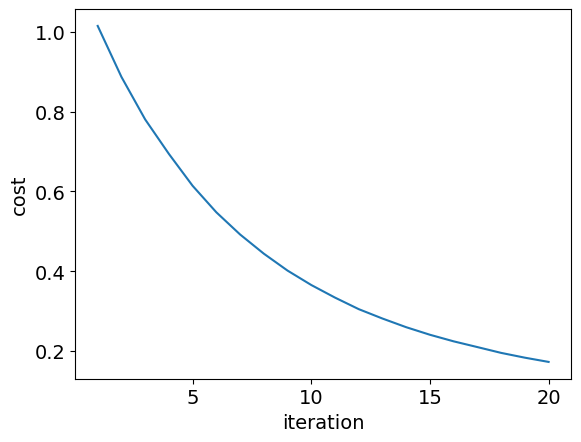

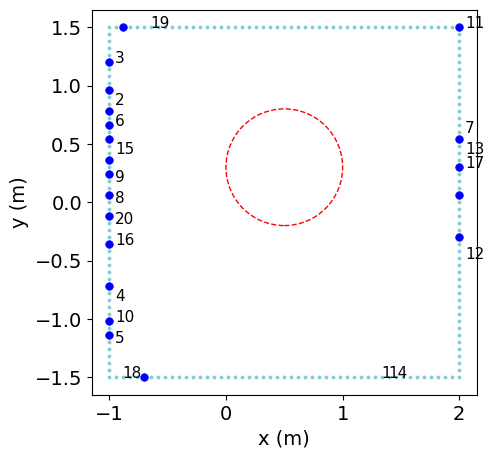

In [35]:
# Source optimization

# Gamma
gam = np.ones_like(f_target)
# gam = 1/f_target
# gam = -f_target+3000
gam = gam/sum(gam)

# Weight matrix list
W_list = []
for f in f_target:
    k = 2*np.pi*f/c
    w = np.zeros((2*N+1,2*N+1), dtype=complex)
    for n in range(-N, N+1):
        idx = n+N
        w[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    
    W_list.append(w)

# Prior information
Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
mu = np.zeros(2*N+1, dtype=complex)
for i in range(-N,N+1):
    for j in range(-N,N+1):
        if i != j:
            Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4))
        else:
            Sig[j+N,i+N] = np.pi/2

# Transfer function matrix list
G_l = np.zeros((len(fbin),2*N+1,len(posSrc)), dtype=complex)
for f in range(len(fbin)):
    k = 2*np.pi*fbin[f]/c
    for i, src in enumerate(room_all.sources):
        src_and_imgs = src.get_images().T
        order = src.orders
        for j, pos in enumerate(src_and_imgs):
            decay = reflect**order[j]
            G_l[f, :, i] += cylindricalwave_coef(cent[:2], pos, k, N) * decay

# Regularization parameter list
lmds = []
for idx in range(len(W_list)):
    lmds.append(np.linalg.norm(G_l[idx].conj().T @ W_list[idx] @ G_l[idx], ord=2) * 1e-3)


# Greedy algorithm
bbselect = []
unselect = list(range(len(posSrc)))
costs = []

while len(bbselect) < L:
    minval = 1e6
    for i in unselect:
        E_J = 0
        for idx in range(len(W_list)):
            lmd = lmds[idx]
            E_J += cost_func(bbselect+[i], G_l[idx], Sig, mu, lmd=lmd, W=W_list[idx]) * gam[idx]
        if E_J < minval:
            minval = E_J
            i_src = i

    bbselect.append(i_src)
    unselect.remove(i_src)

    print(len(bbselect),"selected：", i_src)
    costs.append(minval)


# Cost
plt.plot(np.arange(len(costs))+1,costs)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.show()

# Selected position
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
ax.scatter(posSrc[bbselect][:,0],posSrc[bbselect][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[select]):
    pos = [s[0]+0.05,s[1]]
    plt.annotate(i+1,pos,fontsize=11)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.add_patch(obj_zone)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid(False)
ax.set_aspect('equal')
plt.show()

In [36]:
# Transfer function matrix for evaluation points

# cent, radii, posEval, fbin, e_absorptionなどを変更した場合，再計算が必要
G_eval_l = []
for i_f, f in enumerate(fbin):
    G_eval_b = np.zeros((len(posEval),len(posSrc)), dtype=complex)
    for i, src in enumerate(room_all.sources):
        src_and_imgs = src.get_images().T
        order = src.orders
        for j, pos in enumerate(src_and_imgs):
            decay = reflect**order[j]
            svec = np.repeat([pos],len(posEval),axis=0)
            G_eval_b[:, i] += cylindricalwave(posEval[:,:2], svec, 2*np.pi*f/c, amp=decay)
    G_eval_l.append(G_eval_b)
    print(f)
G_eval_l = np.array(G_eval_l)
np.save(f"G_eval_l_{e_absorption}_{fbin[0]}-{fbin[-1]}Hz.npy", G_eval_l)

# 計算済みの場合
# G_eval_l = np.load("G_eval_l_0.2_100-2000Hz.npy")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [37]:
# Comparison (takes a few minutes)
t1 = time.time()

angles = np.arange(-45,46)*np.pi/180

sdrs = []
ave_sdr = []
for i_f, f in enumerate(fbin):
    # Wave number
    k = 2*np.pi*f/c
    
    # Weight matrix
    N = math.ceil(2*k*radi)
    if N < 5:
        N = 5
#     print("Truncation order : ", N)

    W = np.zeros((2*N+1,2*N+1), dtype=complex)
    for n in range(-N, N+1):
        idx = n+N
        W[idx][idx] = np.pi * radi**2 * (special.jv(n, k*radi)**2 - special.jv(n+1, k*radi)*special.jv(n-1, k*radi))    
    
    # Transfer function matrix
    G_b = np.zeros((2*N+1,len(posSrc)), dtype=complex)
    for i, src in enumerate(room_all.sources):
        src_and_imgs = src.get_images().T
        order = src.orders
        for j, pos in enumerate(src_and_imgs):
            decay = reflect**order[j]
            G_b[:, i] += cylindricalwave_coef(cent[:2], pos, k, N) * decay
    
    G_eval_b = G_eval_l[i_f]

    # Prior information
    Sig = np.zeros((2*N+1,2*N+1), dtype=complex)
    mu = np.zeros(2*N+1, dtype=complex)
    for i in range(-N,N+1):
        for j in range(-N,N+1):
            if i != j:
                Sig[j+N,i+N] = 1j**(i-j)/(1j*(i-j))*(np.exp(1j*(i-j)*np.pi/4)-np.exp(-1j*(i-j)*np.pi/4)) - (mu[i+N])**2/(np.pi/2)
            else:
                Sig[j+N,i+N] = np.pi/2 - (mu[i+N])**2/(np.pi/2)
    
    # Greedy algorithm
    sel = []
    unselect = list(range(len(posSrc)))
    costs = [1e6]
    while len(sel) < L:
        minval = 1e6
        for i in unselect:
            J = cost_func(sel+[i], G_b, Sig, mu, W=W, lmd=lmd)
            if J < minval:
                minval = J
                i_src = i
        sel.append(i_src)
        unselect.remove(i_src)
        costs.append(minval)
    
    G_opt = G_b[:, sel]
    G_bb= G_b[:, bbselect]
    G_regA = G_b[:, regAIdx]
    G_regB = G_b[:, regBIdx]
    
    # Average SDR
    for phi in angles:
        des = []
        for pos in posEval:
            des.append(planewave([pos[0]-cent[0],pos[1]-cent[1],0], phi, np.pi/2, k))
        des = np.array(des)

        des_coefs = planewave_coef(rvec, phi, np.pi/2, k, N, amp=1, cylind=True)
        
        # drive signal
        lmd = np.linalg.norm(G_opt.conj().T @ W @ G_opt, ord=2) * 1e-3
        drvOpt = np.squeeze( np.linalg.inv(G_opt.conj().T @ W @ G_opt + lmd*np.eye(L, dtype=complex)) @ G_opt.conj().T @ W @ des_coefs )
        
        lmd = np.linalg.norm(G_bb.conj().T @ W @ G_bb, ord=2) * 1e-3
        drvBB = np.squeeze( np.linalg.inv(G_bb.conj().T @ W @ G_bb + lmd*np.eye(L, dtype=complex)) @ G_bb.conj().T @ W @ des_coefs )

        lmd = np.linalg.norm(G_regA.conj().T @ W @ G_regA, ord=2) * 1e-3
        drvRegA = np.squeeze( np.linalg.inv(G_regA.conj().T @ W @ G_regA + lmd*np.eye(L, dtype=complex)) @ G_regA.conj().T @ W @ des_coefs )

        lmd = np.linalg.norm(G_regB.conj().T @ W @ G_regB, ord=2) * 1e-3
        drvRegB = np.squeeze( np.linalg.inv(G_regB.conj().T @ W @ G_regB + lmd*np.eye(L, dtype=complex)) @ G_regB.conj().T @ W @ des_coefs )

        # SDR
        opt = G_eval_b[:,sel]@drvOpt
        bb = G_eval_b[:,bbselect]@drvBB
        regA = G_eval_b[:,regAIdx]@drvRegA
        regB = G_eval_b[:,regBIdx]@drvRegB

        sdrs.append([SDR(des, opt), SDR(des, bb), SDR(des, regA), SDR(des, regB)])
        
#         print(f, " Hz, ", round(ang*180/np.pi,0), "° done.")
    print(f, "Hz done.") 
    ave_sdr.append(np.mean(sdrs[i_f*len(angles):(i_f+1)*len(angles)], axis=0))
    
sdrs = np.array(sdrs)
ave_sdr = np.array(ave_sdr)

t2 = time.time()
t2-t1

100 Hz done.
200 Hz done.
300 Hz done.
400 Hz done.
500 Hz done.
600 Hz done.
700 Hz done.
800 Hz done.
900 Hz done.
1000 Hz done.
1100 Hz done.
1200 Hz done.
1300 Hz done.
1400 Hz done.
1500 Hz done.
1600 Hz done.
1700 Hz done.
1800 Hz done.
1900 Hz done.
2000 Hz done.


202.20485091209412

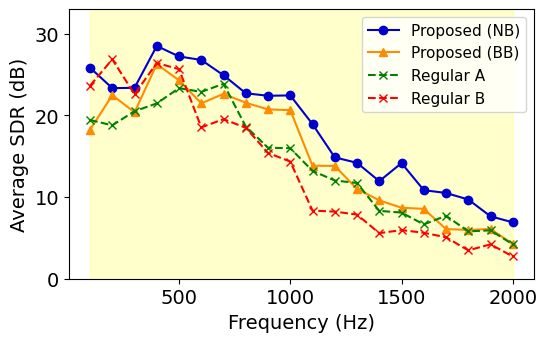

In [38]:
# Plot 

plt.figure(figsize=(6,3.5))
plt.plot(fbin,ave_sdr[:,0],label="Proposed (NB)",marker="o",c="mediumblue",markeredgecolor="mediumblue",alpha=1)
plt.plot(fbin,ave_sdr[:,1],label="Proposed (BB)",linestyle="-",marker="^",c="darkorange",markeredgecolor="darkorange",alpha=1)
plt.plot(fbin,ave_sdr[:,2],label="Regular A",linestyle="--",marker="x",c="green",markeredgecolor="green",alpha=1)
plt.plot(fbin,ave_sdr[:,3],label="Regular B",linestyle="--",marker="x",c="red",markeredgecolor="red",alpha=1)
plt.fill_between([fbin[0],fbin[-1]],[80,80],color="yellow",alpha=0.2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Average SDR (dB)")

plt.ylim([0,33])
plt.legend(fontsize=11)
# plt.savefig(f"results/SDR_bb_room.pdf",bbox_inches='tight')
plt.show()

### 論文用figure作成コード

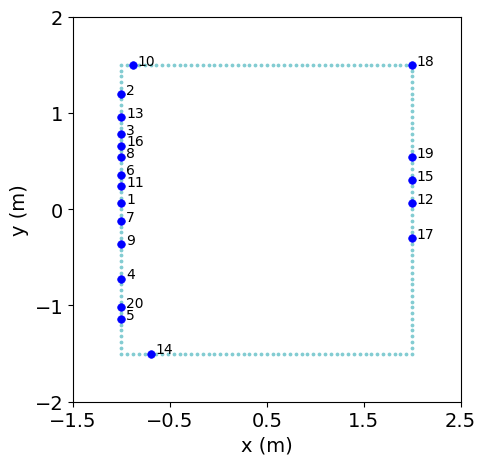

In [39]:
# Source position
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(posSrc[:,0],posSrc[:,1],s=3,c='#83ccd2')
ax.scatter(posSrc[bbselect][:,0],posSrc[bbselect][:,1], marker='o', linewidth=0.5, s=30, c='blue')
for i,s in enumerate(posSrc[bbselect]):
    pos = [s[0]+0.05,s[1]]
    ax.annotate(i+1,pos,fontsize=10)
obj_zone = patches.Circle(xy=cent, radius=radi, ec="red", fill=False, ls='dashed')
ax.set_xticks(np.arange(x_lim[0],x_lim[-1]+0.01,1))
ax.set_yticks(np.arange(y_lim[0],y_lim[-1]+0.01,1))
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.grid(False)

# plt.savefig("figs/select_bb_room.pdf",bbox_inches='tight')
plt.show()

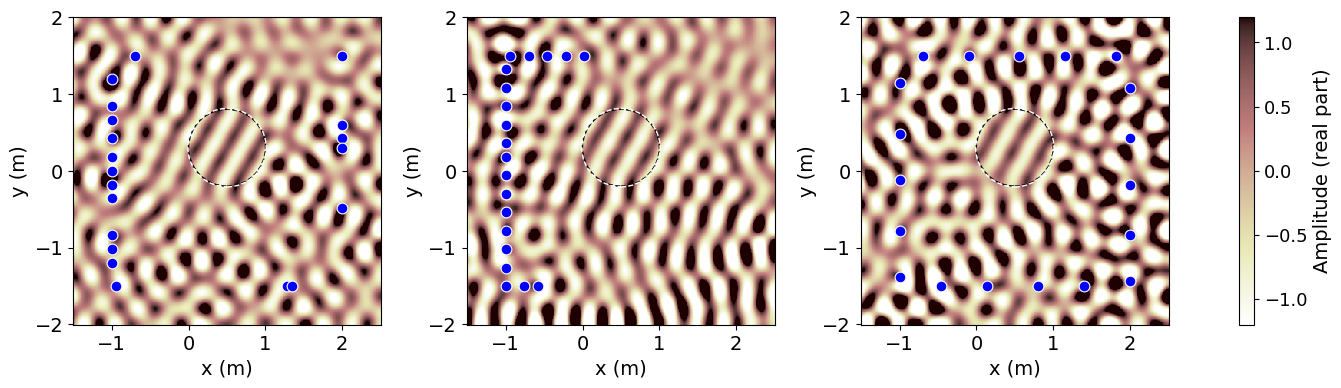

In [40]:
# Amplitude distribution
fig, ax = plt.subplots(1,3,figsize=(18,4))

syn = [sf_opt, sf_regA, sf_regB]
src = [posSrc[select,:2], posSrc[regAIdx,:2], posSrc[regBIdx,:2]]
for n in range(3):
    quadmesh = ax[n].pcolormesh(X, Y, syn[n].real,cmap="pink_r")
    ax[n].set_aspect('equal')
    quadmesh.set_clim(vmin=-1.2, vmax=1.2)
    ax[n].grid(False)

    ax[n].set_xlabel("x (m)")
    ax[n].set_ylabel("y (m)")
    
    ax[n].scatter(src[n][:,0], src[n][:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")
    
    obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone)
    obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone2)

# plt.tight_layout()
cbar = fig.colorbar(quadmesh, ax=ax, ticks=np.arange(-1,1+0.001,0.5))
cbar.set_label("Amplitude (real part)")
cbar.ax.tick_params(labelsize=13)
# plt.savefig("figs/amp_room.pdf")
plt.show()

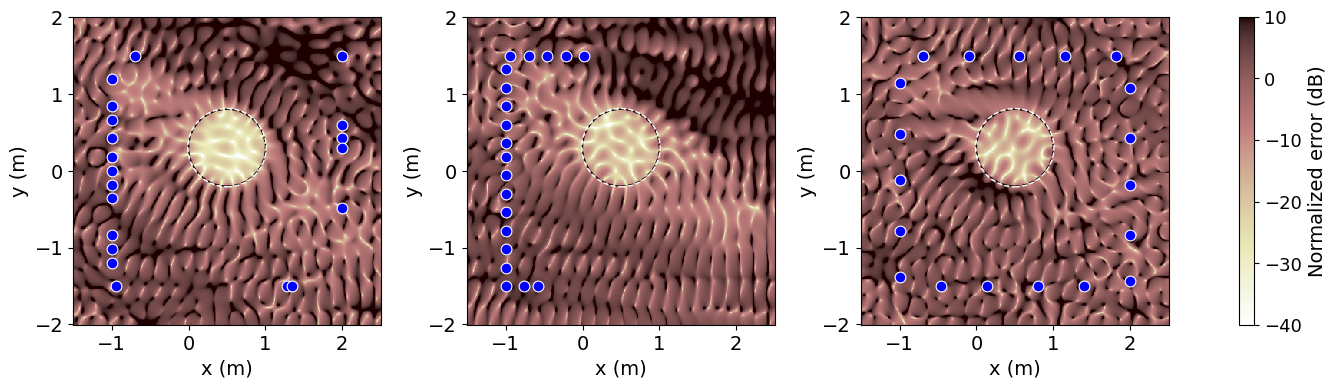

In [41]:
# Normalized error distribution
fig, ax = plt.subplots(1,3,figsize=(18,4))

syn = [sf_opt, sf_regA, sf_regB]
src = [posSrc[select,:2], posSrc[regAIdx,:2], posSrc[regBIdx,:2]]
for n in range(3):
    ne = 10 * np.log10( abs(sf_des-syn[n])**2/abs(syn[n])**2 )
    quadmesh = ax[n].pcolormesh(X,Y, ne.real,cmap="pink_r")
    ax[n].set_aspect('equal')
    quadmesh.set_clim(vmin=-40,vmax=10)
    ax[n].grid(False)

    ax[n].set_xlabel("x (m)")
    ax[n].set_ylabel("y (m)")
    
    ax[n].scatter(src[n][:,0], src[n][:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")
    
    obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone)
    obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
    ax[n].add_patch(obj_zone2)

# plt.tight_layout()
cbar = fig.colorbar(quadmesh, ax=ax)
cbar.set_label("Normalized error (dB)")
cbar.ax.tick_params(labelsize=13)
# plt.savefig("figs/ne_room.pdf")
plt.show()

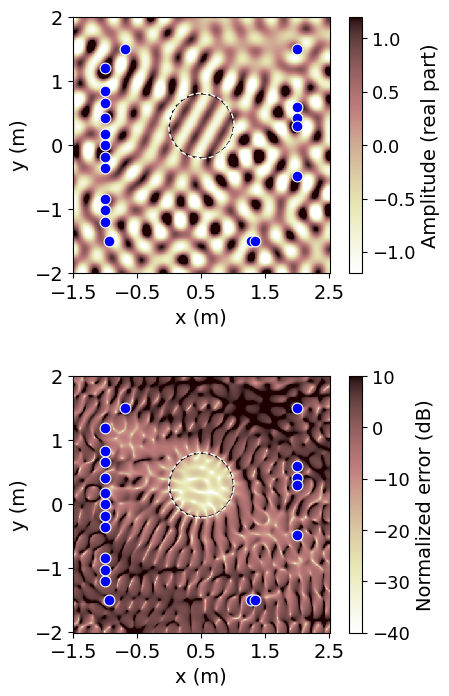

In [42]:
# Plot distribution
fig, ax = plt.subplots(2,1,figsize=(5,8))
syn = sf_opt
src = posSrc[select,:2]

quadmesh = ax[0].pcolormesh(X,Y, syn.real,cmap="pink_r")
ax[0].set_aspect('equal')
quadmesh.set_clim(vmin=-1.2, vmax=1.2)
ax[0].grid(False)

ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")

ax[0].scatter(src[:,0], src[:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")

obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
ax[0].add_patch(obj_zone)
obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
ax[0].add_patch(obj_zone2)

ax[0].set_xticks(np.arange(x_lim[0], x_lim[-1]+0.01,1))

cbar = fig.colorbar(quadmesh, ax=ax[0], ticks=np.arange(-1,1+0.001,0.5))
cbar.set_label("Amplitude (real part)")
cbar.ax.tick_params(labelsize=13)


ne = 10 * np.log10( abs(sf_des-syn)**2/abs(syn)**2 )
quadmesh = ax[1].pcolormesh(X,Y, ne.real,cmap="pink_r")
ax[1].set_aspect('equal')
quadmesh.set_clim(vmin=-40,vmax=10)
ax[1].grid(False)

ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("y (m)")

ax[1].scatter(src[:,0], src[:,1], s=60, linewidth=0.8, marker='o', c="blue", label="Source", edgecolor="white")

obj_zone = patches.Circle(xy=cent, radius=radi, ec='#000000', fill=False, ls='dashed')
ax[1].add_patch(obj_zone)
obj_zone2 = patches.Circle(xy=cent, radius=radi+0.01, ec='#ffffff', fill=False, ls='dashed')
ax[1].add_patch(obj_zone2)

ax[1].set_xticks(np.arange(x_lim[0], x_lim[-1]+0.01,1))

cbar = fig.colorbar(quadmesh, ax=ax[1])
cbar.set_label("Normalized error (dB)")
cbar.ax.tick_params(labelsize=13)

plt.subplots_adjust(wspace=0.0, hspace=0.4)

# plt.savefig("figs/opt_0_freefield.pdf")
plt.show()